# Deeper CNNs 

See https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8119447



In [4]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import sys
import re
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import random
%matplotlib inline

data = pd.read_csv('../fer2013/fer2013.csv')

In [6]:
print(len(data))
print(len(data.loc[0, 'pixels'].split(' ')))
print(data.groupby('Usage').count()[['emotion']])
data.head()

35887
2304
             emotion
Usage               
PrivateTest     3589
PublicTest      3589
Training       28709


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
#Frequency of each label
print('0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral')
table = data.groupby('emotion').count()[['Usage']]
table['Pct'] = table['Usage']/table['Usage'].sum()
table['Pct'] = table['Pct'].map(lambda x: round(x, 3)*100)
table

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


,Usage,Pct
emotion,,
0,4953,13.8
1,547,1.5
2,5121,14.3
3,8989,25.0
4,6077,16.9
5,4002,11.2
6,6198,17.3


## 1) Converting to numpy datasets

In [8]:
def convert_to_numpy(data):
    X = data[:,1]
    X = np.asarray([np.asarray(X[i].split(" ")) for i in range(X.shape[0])])
    X = np.asarray([X[i].reshape(48,48).astype(int) for i in range(X.shape[0])])
    y = data[:,0]
    return (X,y)

In [9]:
train = data[data['Usage'] == 'Training']
train_X, train_Y = convert_to_numpy(train.values)
valid = data[data['Usage'] == 'PrivateTest']
valid_X, valid_Y = convert_to_numpy(valid.values)
test = data[data['Usage'] == 'PublicTest']
test_X, test_Y = convert_to_numpy(test.values)

## 1.1) Viewing image

#### Q.) how should the pixel values be resized????

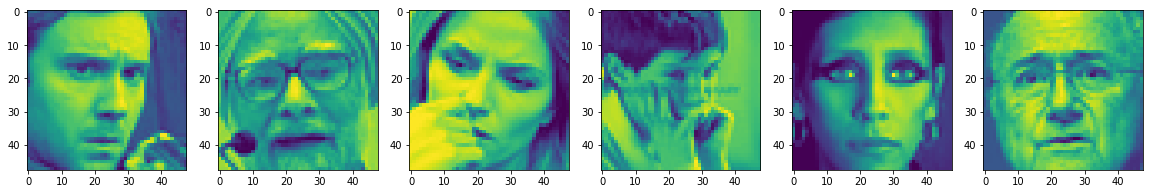

In [10]:
plt.figure(figsize=[20, 10])
for i in range(6):
    pixel = train_X[i].reshape(48,48).astype(int)
    plt.subplot(160+i+1)
    plt.imshow(pixel)

## 2) Function to extract the batches from the dataset

In [11]:
def data_iter(x, y, batch_size, training=True):
    dataset_size = x.shape[0]
    start = -1 * batch_size
    order = list(range(dataset_size))
    if training == True:
        random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            break   
        batch_indices = order[start:start + batch_size]
        yield np.asarray([x[index] for index in batch_indices]) ,np.asarray([y[index] for index in batch_indices])

## 3) Model 

## CNN Implementation

In [12]:
class CNN(nn.Module):
    """
    Baseline CNN model
    """
       
    def __init__(self, kernel_size, num_labels, n_layers=1, dropout=0.1):
       
        """@DEFINE PARAMS"""
        super(CNN,self).__init__()

        self.conv1 = nn.Sequential(
                            nn.Conv2d(1, 10, kernel_size=kernel_size, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            )
        self.conv2 = nn.Sequential(
                            nn.Conv2d(10, 20, kernel_size=kernel_size, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            )
            
        self.out = nn.Linear(20*12*12, num_labels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # Note that normally ppl dont use dropout in CNN
        x = self.out(x)
        return torch.nn.functional.softmax(x)

# Slightly Deeper CNN 

In [16]:
class BKStart(nn.Module):
    """
    From Sang, Dat, Thuan paper (2017)
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8119447
    """
       
    def __init__(self, num_labels, dropout=0.5):
       
        super(BKStart, self).__init__()

        self.conv1 = nn.Sequential(
                            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
                            )
        self.conv2 = nn.Sequential(
                            nn.Conv2d(32, 32, kernel_size=4, stride=1, padding=1),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=3, stride=2)
                            )
        self.conv3 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=3, stride = 2)
                            )
        self.FC = nn.Sequential(nn.Linear(64*3*3, 64),
                                nn.ReLU(),
                                nn.Dropout(dropout)
                               )
        self.out = nn.Linear(64, num_labels)
    
    def forward(self, x):
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) 
        x = self.FC(x)
        x = self.out(x)
        return torch.nn.functional.softmax(x)


In [13]:
class BK12(nn.Module):
    """
    From Sang, Dat, Thuan paper (2017)
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8119447
    """
       
    def __init__(self, num_labels, dropout=0.5):
       
        super(BK12, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Sequential(
                            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv1b = nn.Sequential(
                            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv2 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv2b = nn.Sequential(
                            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv3 = nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv3b = nn.Sequential(
                            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )  
        self.conv4 = nn.Sequential(
                            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv4b = nn.Sequential(
                            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.conv4c = nn.Sequential(
                            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )
        self.FC1 = nn.Sequential(nn.Linear(256*6*6, 256),
                                nn.ReLU(),
                                nn.Dropout(dropout))
        self.FC2 = nn.Sequential(nn.Linear(256, 256),
                                nn.ReLU(),
                                nn.Dropout(dropout))
        self.out = nn.Linear(256, num_labels)
    
    def forward(self, x):
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = self.MaxPool(self.conv1b(self.conv1(x)))
        x = self.MaxPool(self.conv2b(self.conv2(x)))
        x = self.MaxPool(self.conv3b(self.conv3(x)))
        x = self.conv4c(self.conv4b(self.conv4(x)))
        x = x.view(x.size(0), -1) 
        x = self.FC2(self.FC1(x))
        x = self.out(x)
        return torch.nn.functional.softmax(x)

## 4) Training stage setup

In [14]:
def train(train_X, train_Y, valid_X, valid_Y, optimizer, model, batch_size, num_epochs):
    total_batches = int(train_X.shape[0]/batch_size)
    valid_losses = []
    
    eval_every = 20
    print_every = 20
    validate_every = int((eval_every/100)*total_batches)
    show_every = int((print_every/100)*total_batches)
    
    for epoch in range(1, num_epochs+1):
        losses = [] #list of batch losses for the epoch
        stop_training = False
        train_data = data_iter(train_X, train_Y, batch_size)
        for i, (x,y) in enumerate(train_data):
            x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
            y = Variable(torch.from_numpy(y).type(torch.LongTensor))
            model.train(True)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y) #"loss" is batch loss
            losses.append(loss.data[0])
            loss.backward()
            optimizer.step()
            
            if (i+1)%validate_every == 0 or i+1 == total_batches:
                valid_loss_temp = [] #list of batch losses
                #Set batch size to 97, since len(valid_X)=3589 is divisible by 97.
                valid_data = data_iter(valid_X, valid_Y, 97, training=False)
                correct =  0
                for j, (v_x, v_y) in enumerate(valid_data):
                    v_x = Variable(torch.from_numpy(v_x).type(torch.FloatTensor))
                    model.eval()
                    val_output = model(v_x)
                    pred_y = torch.max(val_output, 1)[1].data.numpy().squeeze()
                    correct = correct + sum(pred_y == v_y)
                valid_accuracy = correct/len(valid_Y)
                                                
            if (i+1) % show_every == 0:
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train loss (last batch): {4}, Validation Acc: {5}%'.format(
                    epoch, num_epochs, i+1, total_batches, 
                    round(loss.data[0], 4), round(valid_accuracy*100,2)))
        
            if i+1 == total_batches: #At end of each epoch
                print('Epoch {0} Complete: Train Loss (Per Batch): {1}, Validation Acc: {2}%\n'.format(
                    epoch, round(np.mean(losses), 4), round(valid_accuracy*100,2)))

## 5) Training the model

### BKStart Model

In [18]:
num_labels = 7
num_epochs = 5
learning_rate = 0.00005
batch_size = 80

BKmodel = BKStart(num_labels, dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BKmodel.parameters(), lr=learning_rate)
train(train_X, train_Y, valid_X, valid_Y, optimizer, BKmodel, batch_size, num_epochs)

Epoch: [1/5], Step: [71/358], Train loss (last batch): 1.898, Validation Acc: 24.52%
Epoch: [1/5], Step: [142/358], Train loss (last batch): 1.937, Validation Acc: 24.52%
Epoch: [1/5], Step: [213/358], Train loss (last batch): 1.8754, Validation Acc: 25.61%
Epoch: [1/5], Step: [284/358], Train loss (last batch): 1.852, Validation Acc: 25.38%
Epoch: [1/5], Step: [355/358], Train loss (last batch): 1.8691, Validation Acc: 25.27%
Epoch 1 Complete: Train Loss (Per Batch): 1.9, Validation Acc: 25.24%

Epoch: [2/5], Step: [71/358], Train loss (last batch): 1.8892, Validation Acc: 27.67%
Epoch: [2/5], Step: [142/358], Train loss (last batch): 1.8321, Validation Acc: 28.48%
Epoch: [2/5], Step: [213/358], Train loss (last batch): 1.919, Validation Acc: 27.44%
Epoch: [2/5], Step: [284/358], Train loss (last batch): 1.8603, Validation Acc: 29.62%
Epoch: [2/5], Step: [355/358], Train loss (last batch): 1.8678, Validation Acc: 30.7%
Epoch 2 Complete: Train Loss (Per Batch): 1.8738, Validation Acc: 

### BK12 model 

In [21]:
num_labels = 7
num_epochs = 40
learning_rate = 0.00005
batch_size = 80

BK12model = BK12(num_labels, dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BK12model.parameters(), lr=learning_rate)
train(train_X, train_Y, valid_X, valid_Y, optimizer, BK12model, batch_size, num_epochs)

Epoch: [1/40], Step: [71/358], Train loss (last batch): 1.911, Validation Acc: 25.13%
Epoch: [1/40], Step: [142/358], Train loss (last batch): 1.7835, Validation Acc: 29.06%
Epoch: [1/40], Step: [213/358], Train loss (last batch): 1.8023, Validation Acc: 31.79%
Epoch: [1/40], Step: [284/358], Train loss (last batch): 1.8542, Validation Acc: 33.32%
Epoch: [1/40], Step: [355/358], Train loss (last batch): 1.8968, Validation Acc: 30.73%
Epoch 1 Complete: Train Loss (Per Batch): 1.8495, Validation Acc: 30.87%

Epoch: [2/40], Step: [71/358], Train loss (last batch): 1.7609, Validation Acc: 35.25%
Epoch: [2/40], Step: [142/358], Train loss (last batch): 1.7125, Validation Acc: 34.52%
Epoch: [2/40], Step: [213/358], Train loss (last batch): 1.8849, Validation Acc: 35.5%
Epoch: [2/40], Step: [284/358], Train loss (last batch): 1.7554, Validation Acc: 36.72%
Epoch: [2/40], Step: [355/358], Train loss (last batch): 1.7912, Validation Acc: 35.89%
Epoch 2 Complete: Train Loss (Per Batch): 1.7981, 

KeyboardInterrupt: 

## 6) Calculating accuracy on test set

In [83]:
#Set batch size to 97, since len(test_X) divisible by 97
test_data = data_iter(test_X, test_Y, 97, training=False)
correct = 0 
predictions = []
actuals = []
model = BK12model

for j, (t_x, t_y) in enumerate(test_data):
    t_x = Variable(torch.from_numpy(t_x).type(torch.FloatTensor))
    model.eval()
    test_output = model(t_x)
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    correct = correct + sum(pred_y == t_y)
    predictions.extend(pred_y)
    actuals.extend(t_y)

test_accuracy = correct/len(test_X)
test_accuracy

0.45918083031485091

In [84]:
results = pd.DataFrame(np.vstack((predictions, actuals))).T.rename(columns={0:'Predicted', 1: 'Actual'})
print(results.groupby('Predicted').count())
results.head()

           Actual
Predicted        
0             729
3            1138
4             737
6             985


,Predicted,Actual
0,0,0
1,6,1
2,0,4
3,3,6
4,3,3


In [85]:
def create_confusion_matrix(results):
    #Rows are predicted values, Columns are actual values 
    table = np.zeros(49).reshape(7,7)
    for p in range(7):
        for a in range(7):
            table[p, a] = len(results[(results['Predicted']==p)&(results['Actual']==a)])
    table = pd.DataFrame(table)
    
    recall_rate_per_emotion = []
    
    for a in range(7): 
        recall_rate = table.loc[a, a]/table[a].sum()
        recall_rate_per_emotion.append(recall_rate)
        table[a] = table[a].astype(int)
    
    recall_rate_per_emotion = [float('%.4f' % round(x, 3)) for x in recall_rate_per_emotion]
    return table, recall_rate_per_emotion

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, pred_labels, actual_labels,
                          normalize=False, recall = False,
                          title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = np.array(cm)

    if normalize:
        if recall == False:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        elif recall == True:
            cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    
    else:
        pass
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(pred_labels))
    plt.xticks(tick_marks, actual_labels, rotation=45, size=14)
    plt.yticks(tick_marks, pred_labels, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
    plt.ylabel('Prediction', size=20)
    plt.xlabel('Actual', size=20)

In [86]:
#Rows are predicted values, Columns are actual values 
table, recalls = create_confusion_matrix(results)
table

,0,1,2,3,4,5,6
0,263,35,118,38,96,98,81
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,60,8,64,744,96,82,84
4,71,8,159,40,300,58,101
5,0,0,0,0,0,0,0
6,73,5,155,73,161,177,341


/Users/Brenton/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


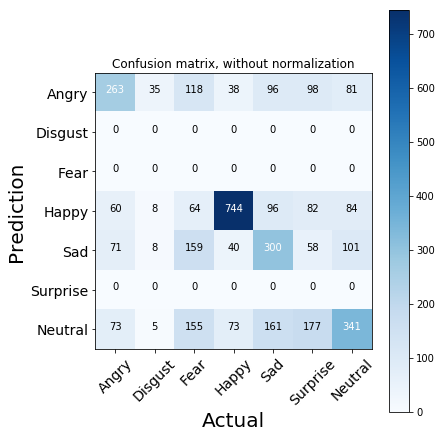

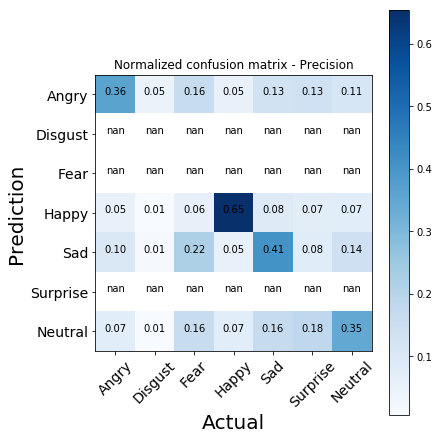

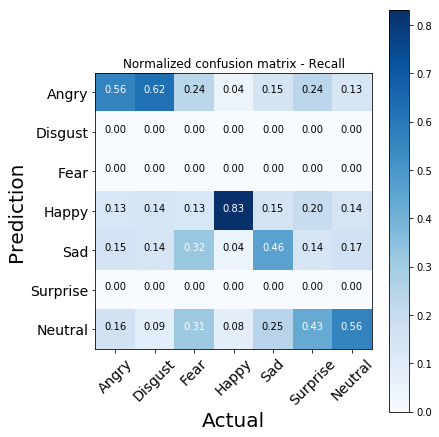

In [87]:
pred_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
actual_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot non-normalized confusion matrix
plt.figure(figsize=[6,6])
plot_confusion_matrix(table, pred_labels, actual_labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=[6,6])

plot_confusion_matrix(table, pred_labels, actual_labels, normalize=True,
                      title='Normalized confusion matrix - Precision',
                     recall = False)

plt.figure(figsize=[6,6])
plot_confusion_matrix(table, pred_labels, actual_labels, normalize=True,
                      title='Normalized confusion matrix - Recall',
                     recall = True)

# Error Analysis 

In [88]:
results[results['Actual']!=results['Predicted']].head()

,Predicted,Actual
1,6,1
2,0,4
3,3,6
6,4,2
7,4,0


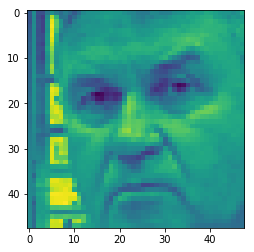

In [90]:
#Predicted Angry (class 0), was actually Sad (class 4)
pixel = test_X[2].reshape(48,48).astype(int)
plt.imshow(pixel)